This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Zonal Stats - Polar Grid


In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import xarray as xr

/home/runner/micromamba-root/envs/wradlib-notebooks/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Examples

In [2]:
def testplot(
    ds,
    obj,
    col="mean",
    levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    title="",
):
    """Quick test plot layout for this example file"""
    colors = pl.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = pl.cm.viridis(np.linspace(0, 1, len(radolevels)))
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors, extend="max")

    fig = pl.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    obj.zdata.trg.geo.plot(
        column=col,
        ax=ax,
        cmap=mycmap,
        norm=mynorm,
        edgecolor="white",
        lw=0.5,
        legend=True,
        legend_kwds=dict(shrink=0.5),
    )
    ax.autoscale()
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title(title)
    pl.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = ds.plot(
        x="xc",
        y="yc",
        cmap=radocmap,
        norm=radonorm,
        ax=ax1,
        cbar_kwargs=dict(shrink=0.5),
    )
    obj.zdata.trg.geo.plot(ax=ax1, facecolor="None", edgecolor="white")
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title("Original radar rain sums")
    pl.draw()
    pl.tight_layout()

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches
import datetime as dt
from osgeo import osr

In [4]:
# check for GEOS enabled GDAL
if not wrl.util.has_geos():
    print("NO GEOS support within GDAL, aborting...")
    exit(0)

In [5]:
# create radolan projection osr object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create UTM Zone 32 projection osr object
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# Source projection of the shape data (in GK2)
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)

0

In [6]:
def create_center_coords(ds, proj=None):
    # create polar grid centroids in GK2
    center = wrl.georef.spherical_to_centroids(
        ds.range.values,
        ds.azimuth.values,
        0.5,
        (ds.longitude.values, ds.latitude.values, ds.altitude.values),
        proj=proj,
    )
    ds = ds.assign_coords(
        {
            "xc": (["azimuth", "range"], center[..., 0]),
            "yc": (["azimuth", "range"], center[..., 1]),
            "zc": (["azimuth", "range"], center[..., 2]),
        }
    )
    return ds

In [7]:
filename = wrl.util.get_wradlib_data_file("hdf5/rainsum_boxpol_20140609.h5")
ds = xr.open_dataset(filename)
ds = ds.rename_dims({"phony_dim_0": "azimuth", "phony_dim_1": "range"})
ds = ds.assign_coords(
    {
        "latitude": ds.data.Latitude,
        "longitude": ds.data.Longitude,
        "altitude": 99.5,
        "azimuth": ds.data.az,
        "range": ds.data.r,
        "sweep_mode": "azimuth_surveillance",
        "elevation": 0.5,
    }
)

ds = ds.pipe(wrl.georef.georeference_dataset, proj=proj_utm)
ds = ds.pipe(create_center_coords, proj=proj_utm)
display(ds)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1000)
Coordinates: (12/16)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range       (range) float64 100.0 200.0 300.0 ... 9.98e+04 9.99e+04 1e+05
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    gr          (azimuth, range) float64 99.98 200.0 ... 9.986e+04 9.996e+04
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float64 100.0 200.0 300.0 ... 9.99e+04 1e+05
    xc          (azimuth, range) float64 3.639e+05 3.639e+05 ... 3.657e+05
    yc          (azimuth, range) float64 5.622e+06 5.622e+06 ... 5.722e+06
    zc          (azimuth, range) float64 100.0 100.9 ... 1.558e+03 1.56e+03
Data variables:
    data        (azimuth, range) float64 ...

In [8]:
# reshape
shpfile = wrl.util.get_wradlib_data_file("shapefiles/agger/agger_merge.shp")
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

bbox = trg.extent

# create catchment bounding box
buffer = 5000.0
bbox = dict(
    left=bbox[0] - buffer,
    right=bbox[1] + buffer,
    bottom=bbox[2] - buffer,
    top=bbox[3] + buffer,
)

In [9]:
ds_clip = ds.where(
    (
        ((ds.yc > bbox["bottom"]) & (ds.yc < bbox["top"]))
        & ((ds.xc > bbox["left"]) & (ds.xc < bbox["right"]))
    ),
    drop=True,
)
display(ds_clip)

<xarray.Dataset>
Dimensions:     (azimuth: 86, range: 695)
Coordinates: (12/16)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 4.5 ... 82.5 83.5 84.5 85.5
  * range       (range) float64 2.8e+03 2.9e+03 3e+03 ... 7.21e+04 7.22e+04
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    gr          (azimuth, range) float64 2.799e+03 2.899e+03 ... 7.217e+04
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 85.5 85.5 85.5 85.5
    bins        (azimuth, range) float64 2.8e+03 2.9e+03 ... 7.21e+04 7.22e+04
    xc          (azimuth, range) float64 3.64e+05 3.64e+05 ... 4.359e+05
    yc          (azimuth, range) float64 5.624e+06 5.624e+06 ... 5.625e+06
    zc          (azimuth, range) float64 124.1 124.9 ... 1.034e+03 1.036e+03
Data variables:
    data        (azimuth, range) float64 nan nan nan nan nan ... nan nan nan nan

In [10]:
radar_utmc = np.dstack([ds_clip.xc, ds_clip.yc]).reshape(-1, 2)
radar_utmc.shape

(59770, 2)

## Zonal Stats Polar Grid - Points

In [11]:
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
src = wrl.io.VectorSource(radar_utmc, srs=proj_utm, name="src")

In [12]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
# - for polar grids a range-area dependency has to be taken into account
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(src, trg, srs=proj_utm, buf=500.0)
# dump to file
zd.dump_vector("test_zonal_points")
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs
t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
obj1 = wrl.zonalstats.ZonalStatsPoint("test_zonal_points")
# Compute stats for target polygons
avg1 = obj1.mean(ds_clip.data.values.ravel())
var1 = obj1.var(ds_clip.data.values.ravel())

t4 = dt.datetime.now()

print("Approach #1 computation time:")
print("\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

Approach #1 computation time:
	Create object from scratch: 3.754332 seconds
	Create object from dumped file: 1.268402 seconds
	Compute stats using object: 0.000036 seconds


In [13]:
src1 = wrl.io.VectorSource(radar_utmc, srs=proj_utm, name="src")
trg1 = wrl.io.VectorSource(
    shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2
)

# Just a test for plotting results with zero buffer
zd = wrl.zonalstats.ZonalDataPoint(src1, trg1, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd)
obj2.zdata.trg.set_attribute("mean", avg1)
obj2.zdata.trg.set_attribute("var", var1)

isecs2 = obj2.zdata.isecs

Text(0.5, 1.0, 'Catchment #0: Points considered for stats')

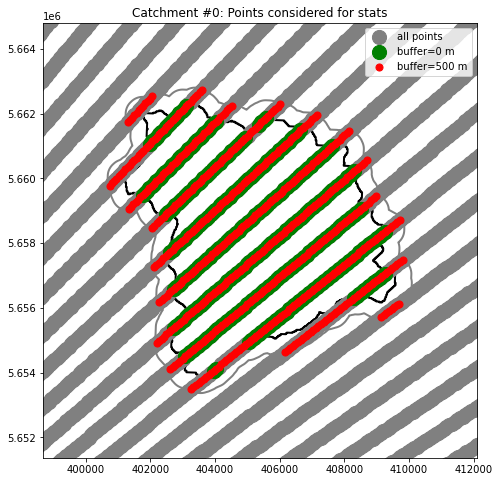

In [14]:
# Illustrate results for an example catchment i
i = 0  # try e.g. 5, 2
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patch = obj2.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=2)
trg_patch = obj1.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="grey", linewidth=2)

# pips
sources = obj1.zdata.src.geo
sources.plot(ax=ax, label="all points", c="grey", markersize=200)
isecs1 = obj2.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(ax=ax, label="buffer=0 m", c="green", markersize=200)
isecs2 = obj1.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs2.plot(ax=ax, label="buffer=500 m", c="red", markersize=50)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Points considered for stats" % i)

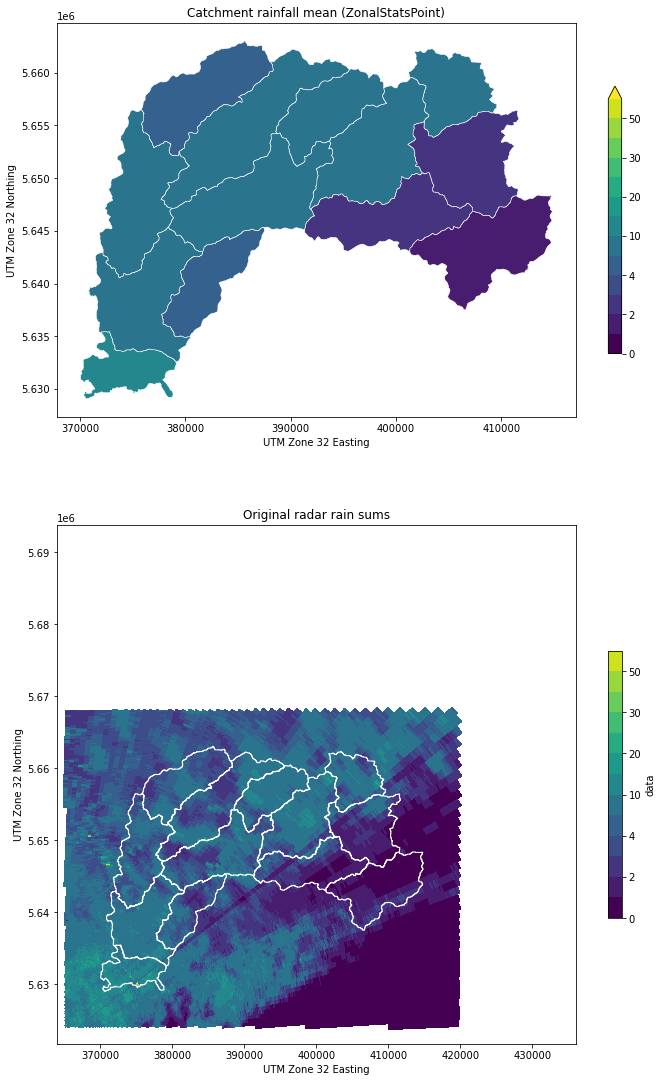

In [15]:
# Plot average rainfall and original data
testplot(
    ds_clip.data, obj2, col="mean", title="Catchment rainfall mean (ZonalStatsPoint)"
)

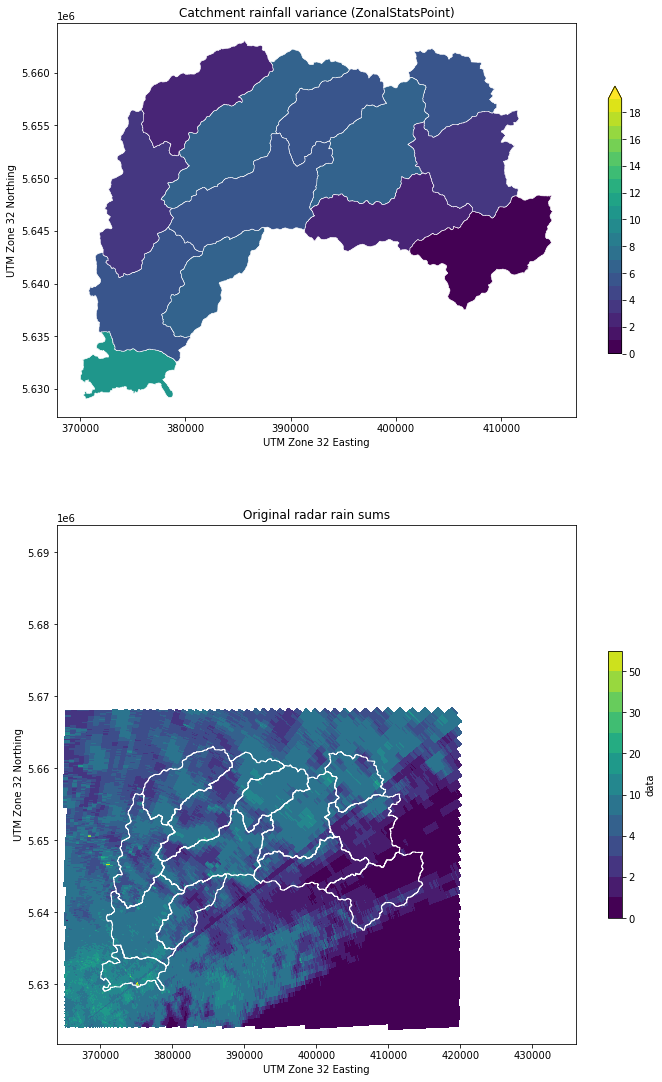

In [16]:
testplot(
    ds_clip.data,
    obj2,
    col="var",
    levels=np.arange(0, 20, 1.0),
    title="Catchment rainfall variance (ZonalStatsPoint)",
)

## Zonal Stats Polar Grid - Polygons

In [17]:
radar_utm = wrl.georef.spherical_to_polyvert(
    ds.range.values,
    ds.azimuth.values,
    0.5,
    (ds.longitude.values, ds.latitude.values, ds.altitude.values),
    proj=proj_utm,
)
radar_utm.shape = (360, 1000, 5, 3)
ds = ds.assign_coords(
    {
        "xp": (["azimuth", "range", "verts"], radar_utm[..., 0]),
        "yp": (["azimuth", "range", "verts"], radar_utm[..., 1]),
        "zp": (["azimuth", "range", "verts"], radar_utm[..., 2]),
    }
)
display(ds)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
bbox = trg.extent

# create catchment bounding box
buffer = 5000.0
bbox = dict(
    left=bbox[0] - buffer,
    right=bbox[1] + buffer,
    bottom=bbox[2] - buffer,
    top=bbox[3] + buffer,
)
ds_clip = ds.where(
    (
        ((ds.yc > bbox["bottom"]) & (ds.yc < bbox["top"]))
        & ((ds.xc > bbox["left"]) & (ds.xc < bbox["right"]))
    ),
    drop=True,
)
display(ds_clip)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1000, verts: 5)
Coordinates: (12/19)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range       (range) float64 100.0 200.0 300.0 ... 9.98e+04 9.99e+04 1e+05
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    xc          (azimuth, range) float64 3.639e+05 3.639e+05 ... 3.657e+05
    yc          (azimuth, range) float64 5.622e+06 5.622e+06 ... 5.722e+06
    zc          (azimuth, range) float64 100.0 100.9 ... 1.558e+03 1.56e+03
    xp          (azimuth, range, verts) float64 3.639e+05 ... 3.648e+05
    yp          (azimuth, range, verts) float64 5.622e+06 ... 5.721e+06
    zp          (azimuth, range, verts) float64 99.56 100.4 ... 1.559e+03
Dimensions without coordinates: verts
Data variables:
    data        (azimuth, range) float64 ...

<xarray.Dataset>
Dimensions:     (azimuth: 86, range: 695, verts: 5)
Coordinates: (12/19)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 4.5 ... 82.5 83.5 84.5 85.5
  * range       (range) float64 2.8e+03 2.9e+03 3e+03 ... 7.21e+04 7.22e+04
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    xc          (azimuth, range) float64 3.64e+05 3.64e+05 ... 4.359e+05
    yc          (azimuth, range) float64 5.624e+06 5.624e+06 ... 5.625e+06
    zc          (azimuth, range) float64 124.1 124.9 ... 1.034e+03 1.036e+03
    xp          (azimuth, range, verts) float64 3.64e+05 3.64e+05 ... 4.358e+05
    yp          (azimuth, range, verts) float64 5.624e+06 ... 5.626e+06
    zp          (azimuth, range, verts) float64 123.6 124.5 ... 1.035e+03
Dimensions without coordinates: verts
Data variables:
    data        (azimuth, range) float64 nan nan nan nan nan ... nan nan nan nan

In [18]:
radar_utm = np.stack([ds_clip.xp, ds_clip.yp], axis=-1).reshape(-1, 5, 2)
print(radar_utm.shape)
src = wrl.io.VectorSource(radar_utm, srs=proj_utm, name="src")
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

(59770, 5, 2)


In [19]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(src, trg, srs=proj_utm)
# dump to file
zd.dump_vector("test_zonal_poly")
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

obj3.zdata.dump_vector("test_zonal_poly")
t2 = dt.datetime.now()


t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj4 = wrl.zonalstats.ZonalStatsPoly("test_zonal_poly")

avg3 = obj4.mean(ds_clip.data.values.ravel())
var3 = obj4.var(ds_clip.data.values.ravel())


t4 = dt.datetime.now()

print("Approach #2 computation time:")
print("\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

obj3.zdata.trg.dump_raster("test_zonal_hdr.nc", "netCDF", "mean", pixel_size=100.0)

obj3.zdata.trg.dump_vector("test_zonal_shp")
obj3.zdata.trg.dump_vector("test_zonal_json.geojson", "GeoJSON")

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

Approach #2 computation time:
	Create object from scratch: 3.170934 seconds
	Create object from dumped file: 1.335817 seconds
	Compute stats using object: 0.000037 seconds


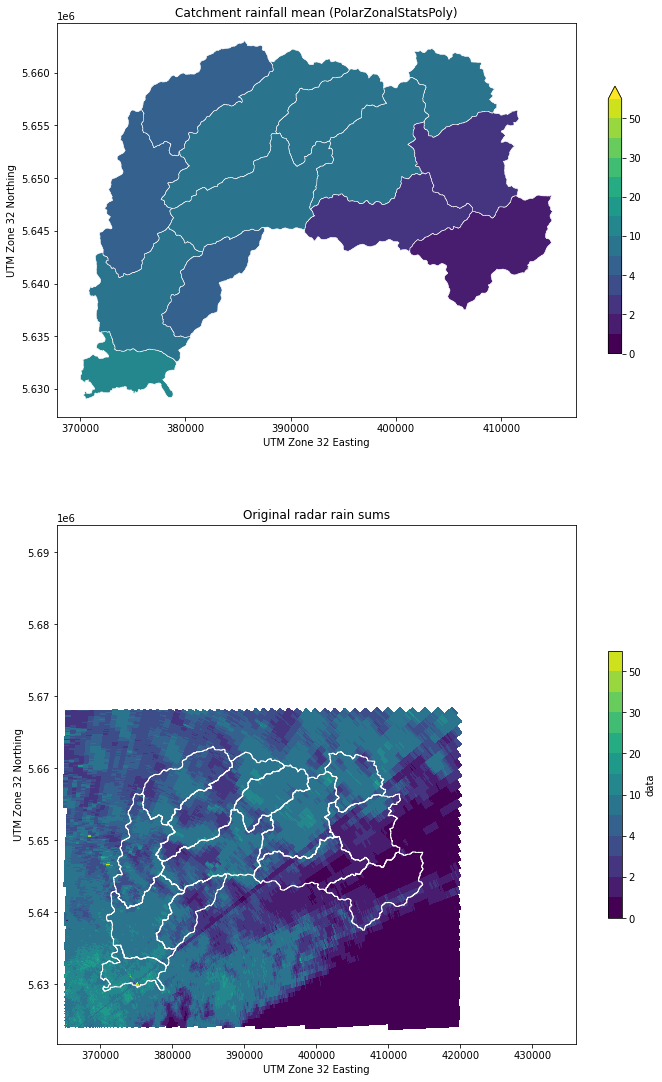

In [20]:
# Plot average rainfall and original data
testplot(
    ds_clip.data,
    obj4,
    col="mean",
    title="Catchment rainfall mean (PolarZonalStatsPoly)",
)

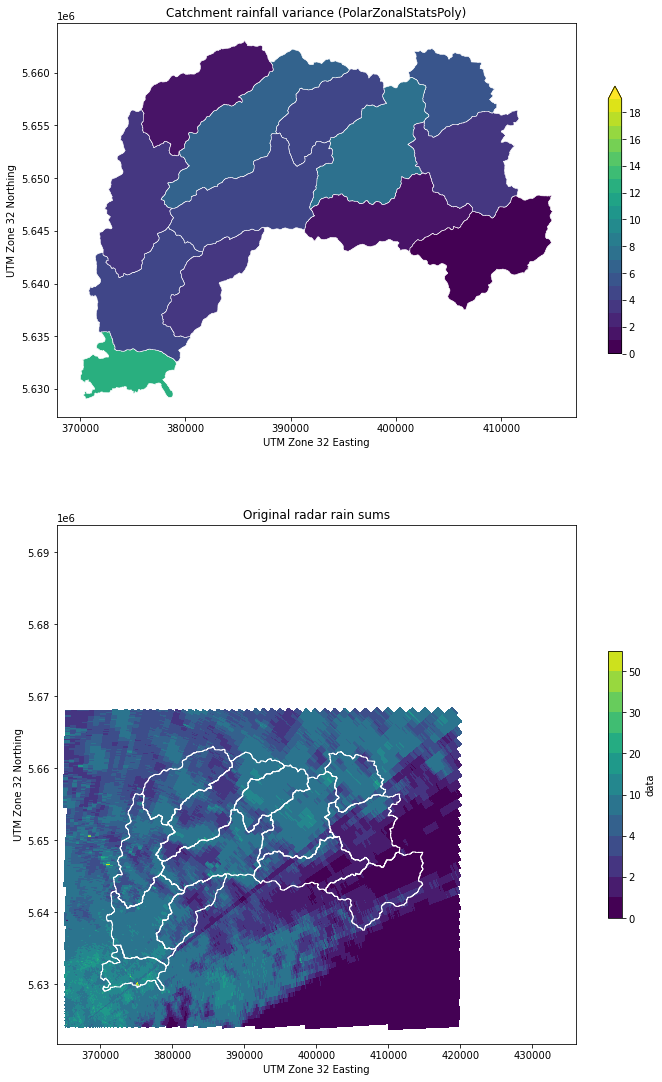

In [21]:
testplot(
    ds_clip.data,
    obj4,
    col="var",
    levels=np.arange(0, 20, 1.0),
    title="Catchment rainfall variance (PolarZonalStatsPoly)",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Catchment #0: Polygons considered for stats')

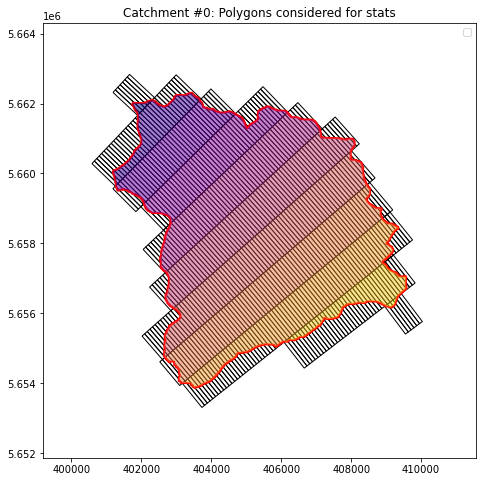

In [22]:
# Illustrate results for an example catchment i
i = 0  # try e.g. 5, 2
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
trg_patch = obj3.zdata.src.get_data_by_idx(src_index, mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black")

# Target polygon patches
trg_patch = obj3.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="red", linewidth=2)

# intersections
isecs1 = obj3.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(column="src_index", ax=ax, cmap=pl.cm.plasma, alpha=0.5)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Polygons considered for stats" % i)

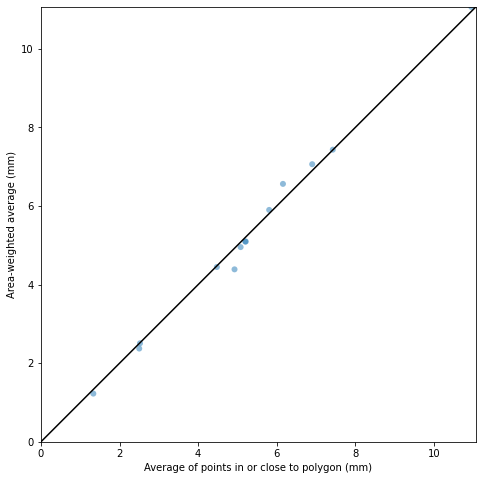

In [23]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
pl.xlabel("Average of points in or close to polygon (mm)")
pl.ylabel("Area-weighted average (mm)")
pl.xlim(0, maxlim)
pl.ylim(0, maxlim)
pl.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
pl.show()